In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd*block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) #gets a 1D Vector of batch size ints between 0 and max
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y: gets each of the numbers at the indices

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [9]:
p.data.dtype

torch.float32

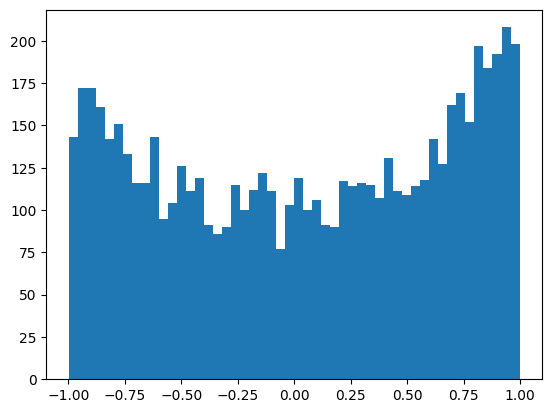

In [ ]:
plt.hist(h.view(-1).tolist(), 50);	#tanh is transforming most inputs to -1 and 1
# backpropagation through tanh when data is close to 1 or -1 leads to gradients of close to 0 (because changing it in the flat area of tanh doesn't change much)
# the gradient can only decrease through a tanh backprop -> destroys gradients
# can lead to dead neurons, that never activate


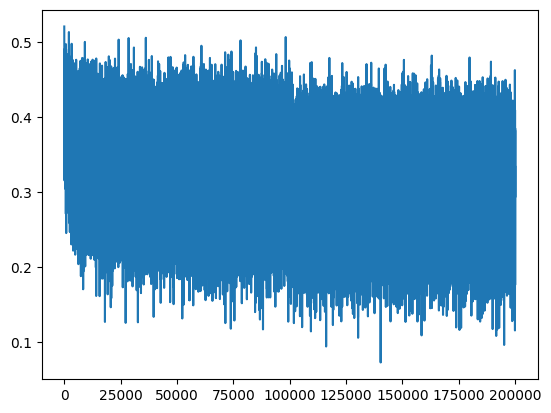

In [ ]:
plt.plot(lossi)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+ b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking: tells pytorch to not track gradients, making it more efficient
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 #+ b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

NameError: name 'bnmean' is not defined

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # concatenate the vectors
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiunrzmuqptcmziivduxlhggphhbmgpoindqbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoiatgtlffhysflquhpqgmovdjhksyjrpmqqosozswjcojqmwyojsfrenqkpfsadlnuo.
zoebsrkoiyzhrynhg.
opklhynrxyh.
xqioloqbplbvbbdn.
ipyqmuitjpbvfpzpddgpycsislqwkkmconzauqnljydpk.
kvweskatikzamdtevl.
ky.
qdyctoorowooktbymouokfbfcw.
zoindzcs.
nu.
eoaignqqerosci.
icfzykbadyieluglconwzyzdjokhnlhjjqsxmuadltjhvtoyaplwuw.
xisxwrmfv.
qphtzbiuzzsrvgmknbfyntiysfgdgkgmmj.
pqgcrvdhpvdafpsdvkhzkxkidtvoscvupgawjmjqjwgvhflwkewtxarclxdytlvhgqllyuil.
hhza.
gfcmkjpoubjbiygh.


In [ ]:
# build the dataset

def build_dataset(words):
	block_size = CONTEXT_LEN # context length: how many chars do we use to predict the next one
	X, Y = [], []

	for w in words:
		#print(w)
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)	#list of lists of the batchsize chars
			Y.append(ix)	#list of the outputs
			context = context[1:] + [ix] #crop context by first element and add ix

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape[0])
	return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))	#get 80% of words
n2 = int(0.9*len(words))	#get 10% words

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

NameError: name 'CONTEXT_LEN' is not defined

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)




12097
      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707
train 2.0674145221710205
val 2.1056838035583496


In [17]:
#Moduling it
class Linear:

	def __init__(self, fan_in, fan_out, bias=False):
		self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5	#draw weights randomly from gaussian and normalize with sqrt(inputs)
		self.bias = torch.zeros(fan_out) if bias else None

	def __call__(self, x):
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out

	def parameters(self):
		return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True	#to use bnmean during training and bnrunning for
		# parameters (trained with backprop)
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# buffers (trained with running momentum update)
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)

	def __call__(self, x):
		# forward pass
		if self.training:
			xmean = x.mean(0, keepdim=True) # batch mean
			xvar = x.var(0, keepdim=True) # batch variance
		else:
			xmean = self.running_mean
			xvar = self.running_var
		xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
		self.out = self.gamma * xhat + self.beta
		# update buffers
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
		return self.out

	def parameters(self):
		return [self.gamma, self.beta]

class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out
	def parameters(self):
		return []

n_embd = 10 # dimensions of character embeddings
n_hidden = 100 # number of hidden neurons
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
	Linear(n_embd * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear(n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear(n_hidden, vocab_size), BatchNorm1D(vocab_size)
]

with torch.no_grad():
	#last layer: make less confident, to stabilize loss
	layers[-1].gamma *= 0.1
	#other layers: apply gain
	for layer in layers[:-1]:
		if isinstance(layer, Linear):
			layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))	#number of parameters in total
for p in parameters:
	p.requires_grad = True

47024


In [18]:
# optimization
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # get loss

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1620
 120000/ 200000: 2.1407
 130000/ 200000: 2.0211
 140000/ 200000: 1.7178
 150000/ 200000: 1.9392
 160000/ 200000: 1.9819
 170000/ 200000: 2.0205
 180000/ 200000: 2.2461
 190000/ 200000: 1.9765


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 20.94%
layer 3 (      Tanh): mean +0.00, std 0.69, saturated: 8.75%
layer 5 (      Tanh): mean +0.01, std 0.68, saturated: 7.47%
layer 7 (      Tanh): mean -0.02, std 0.66, saturated: 5.91%
layer 9 (      Tanh): mean -0.01, std 0.66, saturated: 6.34%


Text(0.5, 1.0, 'activation distribution')

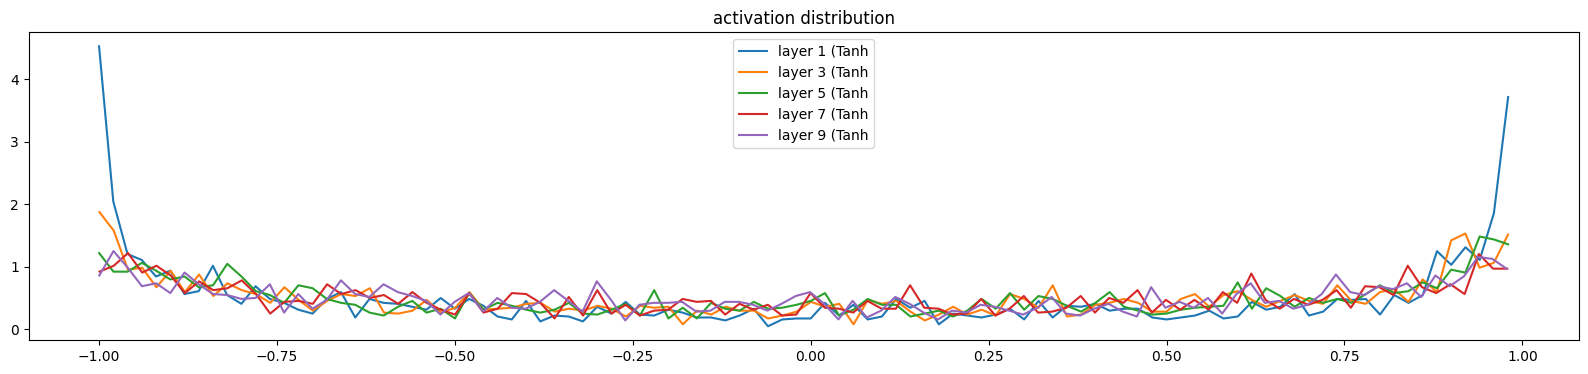

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking: tells pytorch to not track gradients, making it more efficient
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y) # get loss
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9882268905639648
val 1.990570068359375
